In [4]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json

from tqdm import tqdm

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
sns.set_context("notebook")
sns.set_style("dark")

In [7]:
use_example = False
min_event_amount = 0

if use_example:
    with open("example-real-data.json", "rb") as f:
        old_raw_data = json.load(f)
else:
    old_raw_data = {"data": []}
    files = os.listdir("./data/")
    for file in files:
        if file.endswith(".json"):
            print(file)
            with open(f"data/{file}", "rb") as f:
                match_data = json.load(f)
                match_ts = file.replace(".json", "")
                if len(match_data["data"]) < min_event_amount:
                    continue
                old_raw_data["data"] += [{**el, "match_ts": match_ts} for el in match_data["data"]]

2023-11-05T18-07-40.092974.json
2023-11-05T18-30-52.790774.json
2023-11-05T18-55-17.727397.json
2023-11-05T19-14-55.863616.json
2023-11-05T19-25-45.266905.json
2023-11-05T19-40-52.823913.json
2023-11-05T19-58-12.844612.json
2023-11-05T20-13-39.847842.json
2023-11-05T20-22-58.163029.json
2023-11-05T20-45-56.239668.json
2023-11-05T21-43-01.200538.json
2023-11-06T19-40-59.625987.json
2023-11-06T19-48-35.713746.json
2023-11-06T19-59-10.750183.json
2023-11-06T20-03-27.051646.json
2023-11-06T20-17-01.381463.json
2023-11-06T20-55-11.775211.json
2023-11-06T22-58-58.146614.json
2023-11-06T23-09-46.995740.json
2023-11-06T23-17-04.118558.json
2023-11-07T07-59-29.518550.json
2023-11-07T10-56-04.774701.json
2023-11-07T19-11-01.210240.json
2023-11-07T19-20-43.481877.json
2023-11-07T19-44-13.425214.json
2023-11-07T20-04-50.354234.json
2023-11-08T18-46-02.075890.json
2023-11-08T18-55-44.457998.json
2023-11-08T19-03-07.429072.json
2023-11-08T19-14-10.656129.json
2023-11-08T19-33-51.489612.json
2023-11-

In [8]:
len(old_raw_data["data"])

238242

## Loading raw data from analytics system

In [9]:
is_veteran_regex = r'\w+\-\w*V\w*'

In [10]:
show_outliers = False
share_x = 'all'

In [11]:
raw_data = []

for el in old_raw_data["data"]:
    # Value
    if "value" in el:
        el["value"] = float(el["value"])

    # Unique ts of match
    if "i" in el:
        el["i"] = el["i"] + "-" + el["match_ts"]
    if "t" in el:
        el["t"] = el["t"] + "-" + el["match_ts"]
    if "ips" in el:
        el["ips"] = el["ips"] + "-" + el["match_ts"]
    if "tps" in el:
        el["tps"] = el["tps"] + "-" + el["match_ts"]

    # Classes
    if "il" in el and "if" in el:
        el["i-faction-class"] = el["if"] + "-" + el["il"]
        el["i-is-veteran"] = bool(re.search(is_veteran_regex, el["i-faction-class"]))

    if "tl" in el and "tf" in el:
        el["t-faction-class"] = el["tf"] + "-" + el["tl"]
        el["t-is-veteran"] = bool(re.search(is_veteran_regex, el["t-faction-class"]))

    # Instigator coords
    if "ic" in el:
        el["ic_x"] = float(el["ic"].split(" ")[0].split("=")[1])
    if "ic" in el:
        el["ic_y"] = float(el["ic"].split(" ")[1].split("=")[1])

    # Target coords
    if "tc" in el:
        el["tc_x"] = float(el["tc"].split(" ")[0].split("=")[1])
    if "tc" in el:
        el["tc_y"] = float(el["tc"].split(" ")[1].split("=")[1])

    raw_data.append(el)

## Analyzing damage (per pawn, per class)

In [12]:
damage_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Damage"])

In [13]:
# Removing friendly fire when analyzing damage
damage_df = damage_df[damage_df["if"] != damage_df["tf"]]

# Leave only damage from characters to characters
damage_df = damage_df[damage_df['i'].str.startswith("CH_")]
damage_df = damage_df[damage_df['t'].str.startswith("CH_")]

In [14]:
damage_per_pawn = damage_df.groupby(["i"]).agg(
    damage_per_life=('value', 'sum'),
    loadout=('i-faction-class', 'first'),
    is_veteran=('i-is-veteran', 'first'),
    faction=('if', 'first')
)

In [15]:
median_damage_per_pawn = damage_per_pawn["damage_per_life"].median()

In [16]:
damage_per_life_for_classes = damage_per_pawn.sort_values(by='loadout').groupby("loadout").agg(
    mean_damage_per_life=('damage_per_life', 'mean'),
    std_damage_per_life=('damage_per_life', 'std')
)
damage_per_life_for_classes

,mean_damage_per_life,std_damage_per_life
loadout,,
CSM-AucV,1415.344088,1438.072561
CSM-GravCannonStandard,419.678960,548.242208
CSM-HboS,668.858961,744.663017
CSM-JpaS,432.898157,423.530311
CSM-JpaVA,577.235745,647.899048
CSM-LcaS,363.343958,304.155639
CSM-MelS,421.001507,370.579968
CSM-MelV,1354.878360,1362.881628
CSM-PcaS,738.151435,794.826324


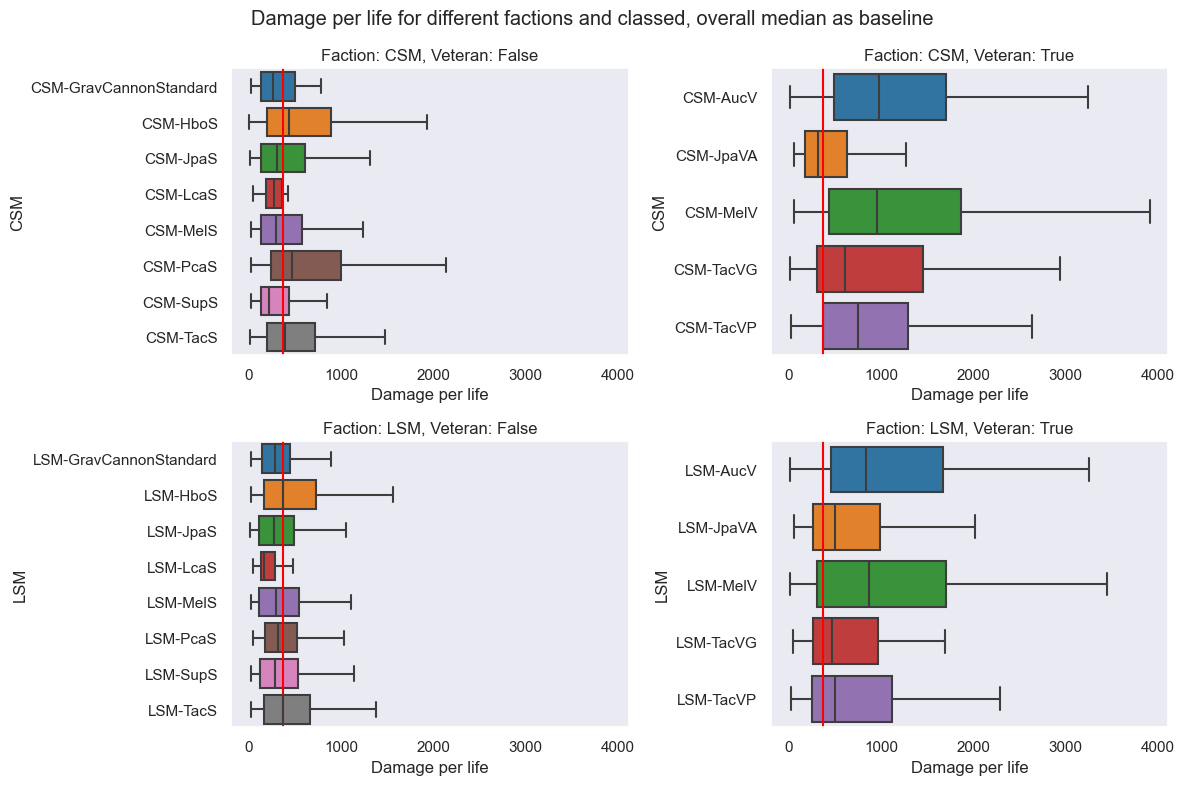

In [17]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(damage_per_pawn['faction'].unique()),
    ncols=len(damage_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(damage_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    sns.boxplot(x='damage_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Damage per life')
    ax.set_ylabel(faction)

    ax.axvline(x=median_damage_per_pawn, color='red')

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)


fig.suptitle("Damage per life for different factions and classed, overall median as baseline")

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing XP (per pawn, per class and action)

In [18]:
xp_df = pd.DataFrame([el for el in raw_data if el["Type"] == "XP"])

# Leave only XP to characters
xp_df = xp_df[xp_df['t'].str.startswith("CH_")]

xp_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,t-is-veteran,tc_x,tc_y
0,CH_2146975868-2023-11-05T18-07-40.092974,400.0,PS_2147467939-2023-11-05T18-07-40.092974,LSM,TacS,X=29432.180 Y=-9899.511 Z=-737.941,Started capture,XP,2023-11-05T18-07-40.092974,LSM-TacS,False,29432.180,-9899.511
1,CH_2146975868-2023-11-05T18-07-40.092974,50.0,PS_2147467939-2023-11-05T18-07-40.092974,LSM,TacS,X=29333.713 Y=-9367.468 Z=-737.941,Assist,XP,2023-11-05T18-07-40.092974,LSM-TacS,False,29333.713,-9367.468
2,CH_2146974363-2023-11-05T18-07-40.092974,100.0,PS_2146989755-2023-11-05T18-07-40.092974,LSM,SupS,X=28608.459 Y=-9791.409 Z=-737.941,Enemy down,XP,2023-11-05T18-07-40.092974,LSM-SupS,False,28608.459,-9791.409
3,CH_2146975868-2023-11-05T18-07-40.092974,100.0,PS_2147467939-2023-11-05T18-07-40.092974,LSM,TacS,X=27615.389 Y=-8031.795 Z=-714.115,Enemy down,XP,2023-11-05T18-07-40.092974,LSM-TacS,False,27615.389,-8031.795
4,CH_2146975868-2023-11-05T18-07-40.092974,50.0,PS_2147467939-2023-11-05T18-07-40.092974,LSM,TacS,X=29005.088 Y=-8580.068 Z=-737.941,Assist,XP,2023-11-05T18-07-40.092974,LSM-TacS,False,29005.088,-8580.068


In [19]:
xp_per_pawn_and_action = xp_df.groupby(["t", "action"]).agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first'),
    is_veteran=('t-is-veteran', 'first'),
    faction=('tf', 'first')
)

In [20]:
xp_per_pawn = xp_df.groupby("t").agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first'),
    is_veteran=('t-is-veteran', 'first'),
    faction=('tf', 'first')
)

In [21]:
xp_per_life_for_class_and_action = xp_per_pawn_and_action.groupby(["loadout", "action"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std'),
    is_veteran=('is_veteran', 'first'),
    faction=('faction', 'first')
)

In [22]:
xp_per_life_for_class = xp_per_pawn.groupby(["loadout"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std')
)
xp_per_life_for_class

,mean_xp_per_life,std_xp_per_life
loadout,,
CSM-AucV,625.678571,715.888755
CSM-GravCannonStandard,334.000000,435.582656
CSM-HboS,389.771242,489.601484
CSM-JpaS,362.237624,416.905292
CSM-JpaVA,630.050000,488.109400
CSM-LcaS,469.565217,634.202995
CSM-MelS,604.483333,681.264543
CSM-MelV,1296.575000,1379.526444
CSM-PcaS,213.287500,464.994656


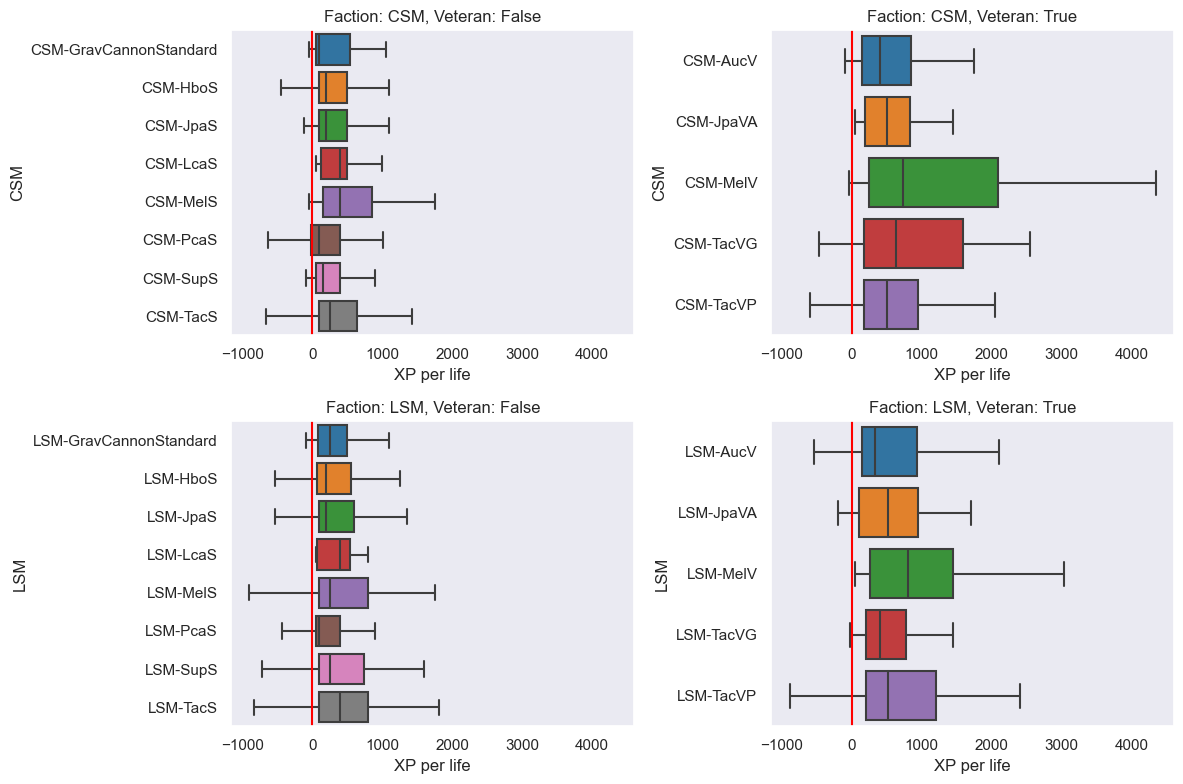

In [23]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(xp_per_pawn['faction'].unique()),
    ncols=len(xp_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(xp_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    sns.boxplot(x='xp_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('XP per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

    ax.axvline(x=0, color='red')


# Adjust layout
plt.tight_layout()
plt.show()

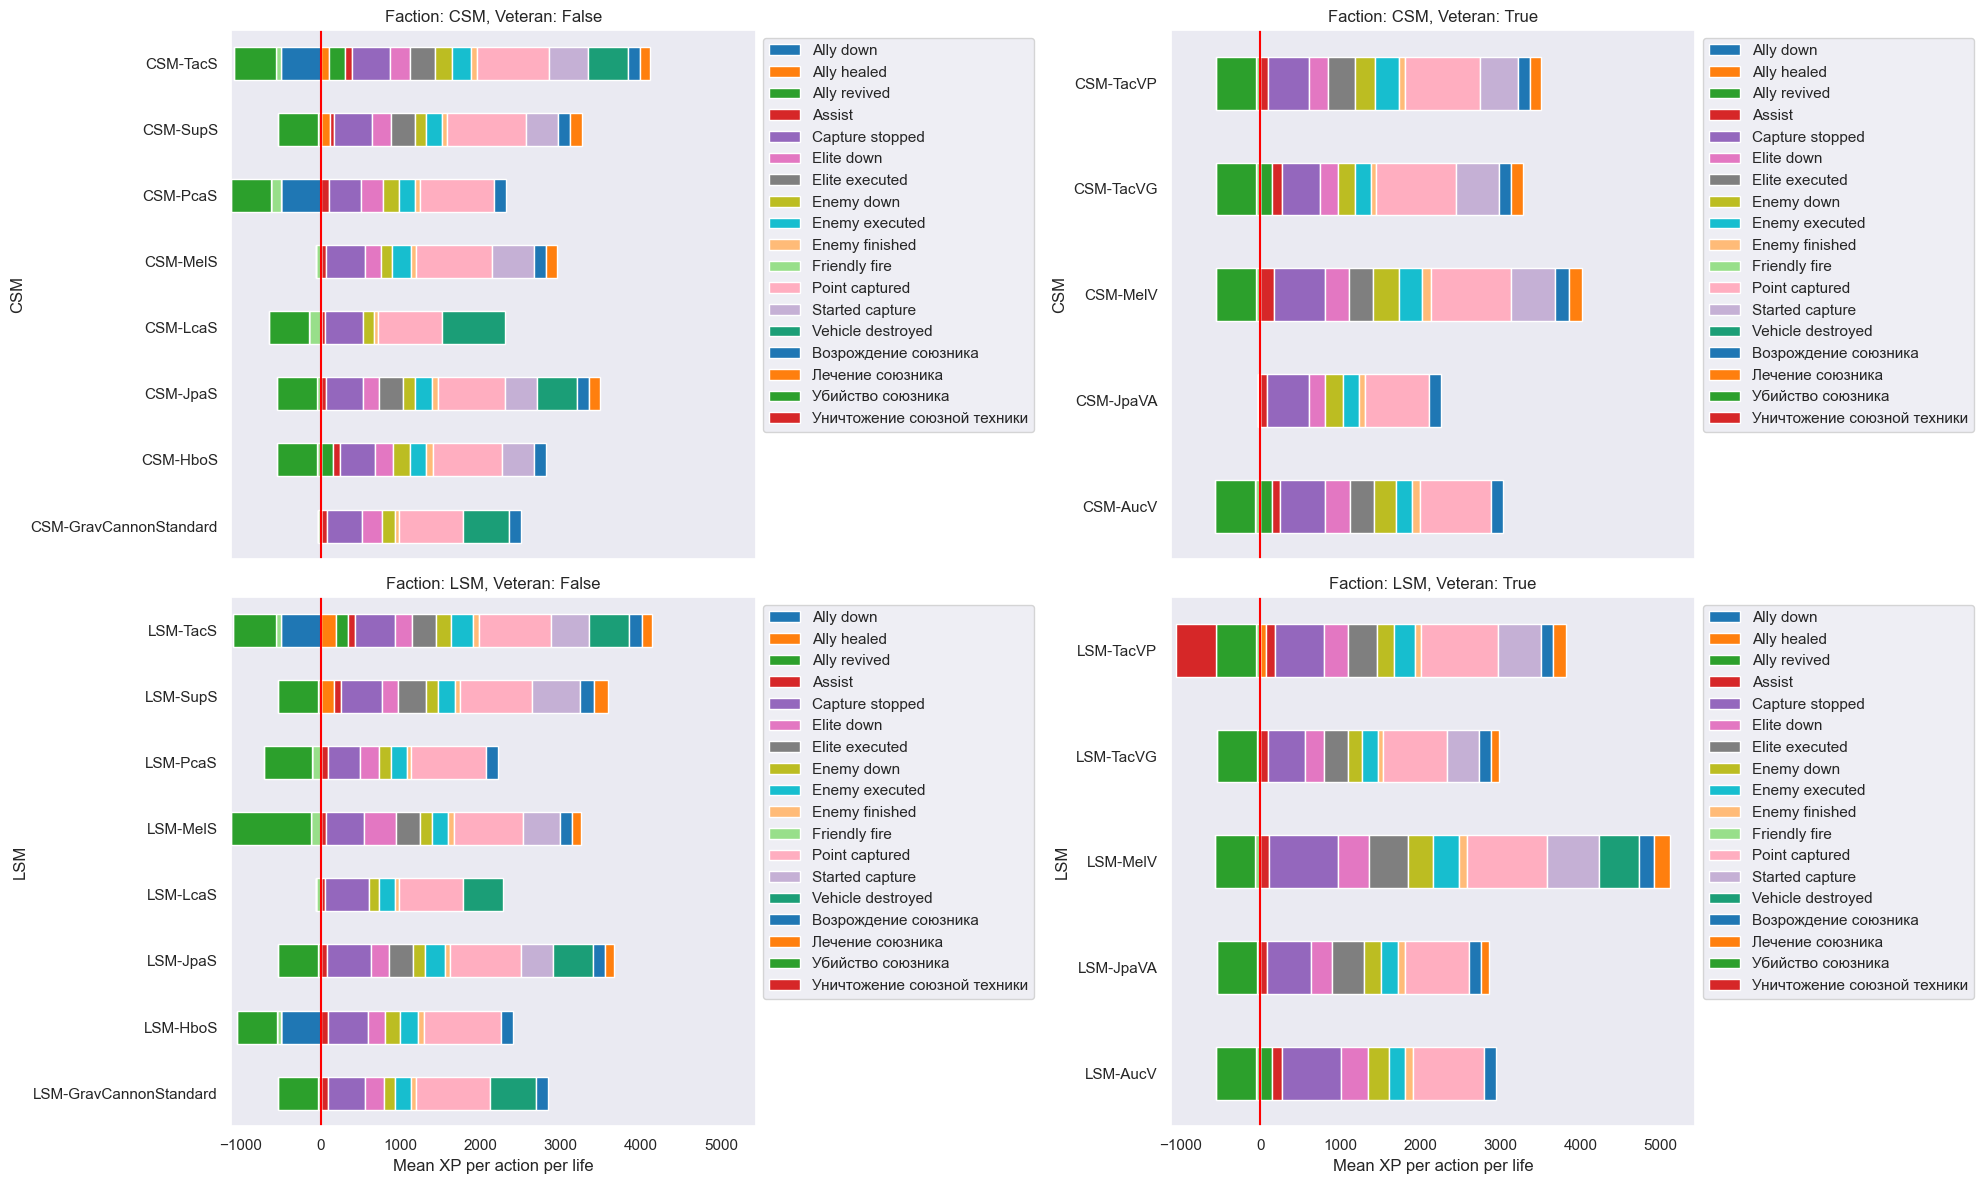

In [24]:
# Create a pivot table to reshape the data for plotting
pivot_xp_per_life_for_class_and_action = xp_per_life_for_class_and_action.reset_index()
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.pivot(index=['loadout', 'faction', 'is_veteran'], columns='action',
                                                                                      values='mean_xp_per_life')
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.reset_index().set_index("loadout")

# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(xp_per_pawn['faction'].unique()),
    ncols=len(xp_per_pawn['is_veteran'].unique()),
    figsize=(24, 16),
    sharex=share_x
)

# Define a custom color palette
custom_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf',  # Cyan
    '#ffbb78',  # Light Orange
    '#98df8a',  # Light Green
    '#ffaec0',  # Light Pink
    '#c5b0d5',  # Light Purple
    '#1b9e77',  # Dark Green
]

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(pivot_xp_per_life_for_class_and_action.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    subset = subset.drop(["faction", "is_veteran"], axis=1)

    # Create a rotated stacked barplot with the custom color palette
    subset.plot(kind='barh', stacked=True, figsize=(20, 12), color=custom_colors, ax=ax)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Mean XP per action per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)
    ax.legend(bbox_to_anchor=(1, 1))

    ax.axvline(x=0, color='red')

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing KS ratios

In [25]:
kills_df = xp_df[xp_df["action"] == "Enemy down"]
kills_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,t-is-veteran,tc_x,tc_y
2,CH_2146974363-2023-11-05T18-07-40.092974,100.0,PS_2146989755-2023-11-05T18-07-40.092974,LSM,SupS,X=28608.459 Y=-9791.409 Z=-737.941,Enemy down,XP,2023-11-05T18-07-40.092974,LSM-SupS,False,28608.459,-9791.409
3,CH_2146975868-2023-11-05T18-07-40.092974,100.0,PS_2147467939-2023-11-05T18-07-40.092974,LSM,TacS,X=27615.389 Y=-8031.795 Z=-714.115,Enemy down,XP,2023-11-05T18-07-40.092974,LSM-TacS,False,27615.389,-8031.795
5,CH_2146974363-2023-11-05T18-07-40.092974,100.0,PS_2146989755-2023-11-05T18-07-40.092974,LSM,SupS,X=29729.354 Y=-9576.520 Z=-737.941,Enemy down,XP,2023-11-05T18-07-40.092974,LSM-SupS,False,29729.354,-9576.520
6,CH_2146960301-2023-11-05T18-07-40.092974,100.0,PS_2147288003-2023-11-05T18-07-40.092974,CSM,TacS,X=29073.757 Y=-9448.251 Z=-737.941,Enemy down,XP,2023-11-05T18-07-40.092974,CSM-TacS,False,29073.757,-9448.251
8,CH_2146961596-2023-11-05T18-07-40.092974,100.0,PS_2146977518-2023-11-05T18-07-40.092974,LSM,HboS,X=27451.789 Y=-9960.848 Z=317.060,Enemy down,XP,2023-11-05T18-07-40.092974,LSM-HboS,False,27451.789,-9960.848


In [26]:
kills_per_pawn = kills_df.groupby(["t"]).agg(
    kill_count=('t', 'count'),
    loadout=('t-faction-class', 'first'),
    faction=('tf', 'first'),
    is_veteran=('t-is-veteran', 'first')
)
kills_per_pawn.head()

,kill_count,loadout,faction,is_veteran
t,,,,
CH_2145091914-2023-11-09T18-31-35.373589,1,CSM-JpaS,CSM,False
CH_2145097865-2023-11-09T18-31-35.373589,2,CSM-AucV,CSM,True
CH_2145107054-2023-11-09T18-31-35.373589,1,LSM-SupS,LSM,False
CH_2145109649-2023-11-09T18-31-35.373589,1,LSM-TacS,LSM,False
CH_2145118669-2023-11-09T18-31-35.373589,3,CSM-JpaS,CSM,False


In [27]:
kills_per_life_for_classes = kills_per_pawn.groupby("loadout").agg(
    mean_kills_per_life=('kill_count', 'mean'),
    std_kills_per_life=('kill_count', 'std')
)
kills_per_life_for_classes

,mean_kills_per_life,std_kills_per_life
loadout,,
CSM-AucV,2.759615,2.656720
CSM-GravCannonStandard,1.560000,1.660321
CSM-HboS,2.042904,1.699671
CSM-JpaS,1.481203,0.926066
CSM-JpaVA,2.142857,1.167321
CSM-LcaS,1.400000,0.516398
CSM-MelS,1.444444,0.798745
CSM-MelV,3.213115,2.602017
CSM-PcaS,2.000000,1.277753


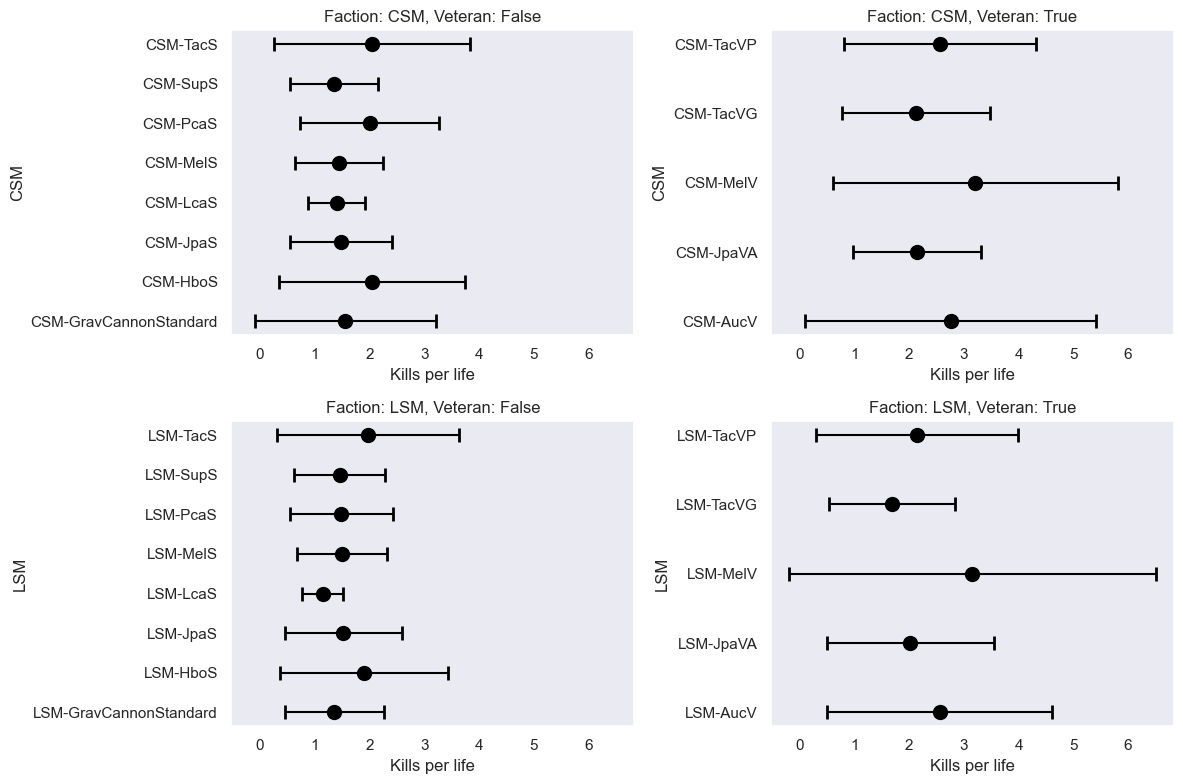

In [28]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(kills_per_pawn['faction'].unique()),
    ncols=len(kills_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(kills_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'

    grouped = subset.groupby('loadout')['kill_count']
    means = grouped.mean()
    stds = grouped.std()

    # Create a horizontal scatter plot for means
    ax.scatter(means, means.index, color='black', label='Mean', s=100, marker='o')  # Adjust the 's' parameter for size

    # Create vertical bars for standard deviation
    for i, (mean_val, std_val) in enumerate(zip(means, stds)):
        ax.errorbar(mean_val, i, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Kills per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing class frequencies

In [29]:
spawn_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Spawn"])

In [30]:
class_spawns = spawn_df["t-faction-class"].value_counts()

<Axes: title={'center': 'Classes spawn frequency'}, ylabel='t-faction-class'>

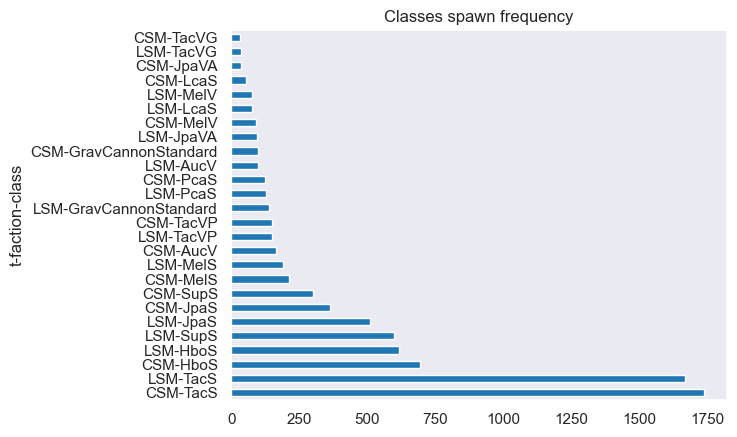

In [31]:
class_spawns.plot.barh(title="Classes spawn frequency")

# Maps and missions

In [32]:
faction_mapping = {
    "LSM": "LoyalSpaceMarines",
    "CSM": "ChaosSpaceMarines"
}

In [33]:
raw_match_end_data = []

def parse_team(team_string):
    try:
        team_data = json.loads(team_string)
    except:
        return None, None, None, None
    team_name = ",".join(sorted(team_data["alliance"]["factionNames"]))
    team_goal = team_data["goal"]
    team_score = team_data["score"]
    team_max_score = team_data["maxScore"]
    return team_name, team_goal, team_score, team_max_score

def parse_winner(winner_string):
    try:
        winner_data = json.loads(winner_string)
    except:
        return None, None
    team_name = ",".join(sorted(winner_data["alliance"]["factionNames"]))
    team_goal = winner_data["goal"]
    return team_name, team_goal

def get_positive_xp_per_team(match_ts, team_name):
    if team_name is None:
        return None

    xp = 0
    for event in raw_data:
        if event["match_ts"] == match_ts and event["Type"] == "XP" and faction_mapping.get(event.get("tf")) in team_name and event["value"] > 0:
            xp += event["value"]
    return xp

def get_kill_spawns_ratio_per_team(match_ts, team_name):
    if team_name is None:
        return None

    spawns = 0
    kills = 0
    for event in raw_data:
        if event["match_ts"] == match_ts and event["Type"] == "Spawn" and faction_mapping.get(event.get("tf")) in team_name:
            spawns += 1
        if event["match_ts"] == match_ts and event["Type"] == "XP" and faction_mapping.get(event.get("tf")) in team_name and event["action"] == "Enemy down":
            kills += 1
    return kills / spawns if spawns != 0 else None

for el in tqdm(old_raw_data["data"]):
    if el["Type"] == "MatchEnd":
        match_ts = el["match_ts"]

        if "map" in el and "mission" in el:
            el["map-mission"] = el["map"] + "_" + el["mission"]

        if "t1" in el:
            el["t1_name"], el["t1_goal"], el["t1_score"], el["t1_max_score"] = parse_team(el["t1"])
            el.pop("t1")

            el["t1_xp"] = get_positive_xp_per_team(match_ts, el["t1_name"])
            el["t1_ks_ratio"] = get_kill_spawns_ratio_per_team(match_ts, el["t1_name"])

        if "t2" in el:
            el["t2_name"], el["t2_goal"], el["t2_score"], el["t2_max_score"] = parse_team(el["t2"])
            el.pop("t2")

            el["t2_xp"] = get_positive_xp_per_team(match_ts, el["t2_name"])
            el["t2_ks_ratio"] = get_kill_spawns_ratio_per_team(match_ts, el["t2_name"])

        if "t3" in el:
            el["t3_name"], el["t3_goal"], el["t3_score"], el["t3_max_score"] = parse_team(el["t3"])
            el.pop("t3")

            el["t3_xp"] = get_positive_xp_per_team(match_ts, el["t3_name"])
            el["t3_ks_ratio"] = get_kill_spawns_ratio_per_team(match_ts, el["t3_name"])

        if "t4" in el:
            el["t4_name"], el["t4_goal"], el["t4_score"], el["t4_max_score"] = parse_team(el["t4"])
            el.pop("t4")

            el["t4_xp"] = get_positive_xp_per_team(match_ts, el["t4_name"])
            el["t4_ks_ratio"] = get_kill_spawns_ratio_per_team(match_ts, el["t4_name"])

        if "winner" in el:
            el["winner_name"], el["winner_goal"] = parse_winner(el["winner"])
            el.pop("winner")

        raw_match_end_data.append(el)

100%|██████████| 238242/238242 [00:25<00:00, 9165.55it/s] 


In [34]:
match_end_df = pd.DataFrame(raw_match_end_data)
print(match_end_df.shape)
match_end_df.head()

(140, 36)


,map,mission,pa,ts,duration,minduration,maxduration,Type,match_ts,map-mission,...,t3_xp,t3_ks_ratio,t4_name,t4_goal,t4_score,t4_max_score,t4_xp,t4_ks_ratio,winner_name,winner_goal
0,CanyonWasteyard,B_GM_Supremacy_CanyonWasteyard_C,,,1230.0,600.0,1230.0,MatchEnd,2023-11-05T18-07-40.092974,CanyonWasteyard_B_GM_Supremacy_CanyonWasteyard_C,...,None,None,None,None,None,None,None,None,ChaosSpaceMarines,Defender
1,PromethiumMine,B_GM_Supremacy_PromethiumMine_C,,,1230.0,600.0,1230.0,MatchEnd,2023-11-05T18-30-52.790774,PromethiumMine_B_GM_Supremacy_PromethiumMine_C,...,None,None,None,None,None,None,None,None,ChaosSpaceMarines,Defender
2,Olipsis,B_GM_Supremacy_Olipsis_C,,,1230.0,600.0,1230.0,MatchEnd,2023-11-05T18-55-17.727397,Olipsis_B_GM_Supremacy_Olipsis_C,...,None,None,None,None,None,None,None,None,LoyalSpaceMarines,Defender
3,Torias,B_GM_Supremacy_ToriasRefinery_C,,,1230.0,600.0,1230.0,MatchEnd,2023-11-05T19-14-55.863616,Torias_B_GM_Supremacy_ToriasRefinery_C,...,None,None,None,None,None,None,None,None,LoyalSpaceMarines,Attacker
4,NexusCitadel,B_GM_Elimination_Nexus_C,,,900.0,900.0,900.0,MatchEnd,2023-11-05T19-25-45.266905,NexusCitadel_B_GM_Elimination_Nexus_C,...,None,None,None,None,None,None,None,None,ChaosSpaceMarines,Standard


## Preferred missions and maps

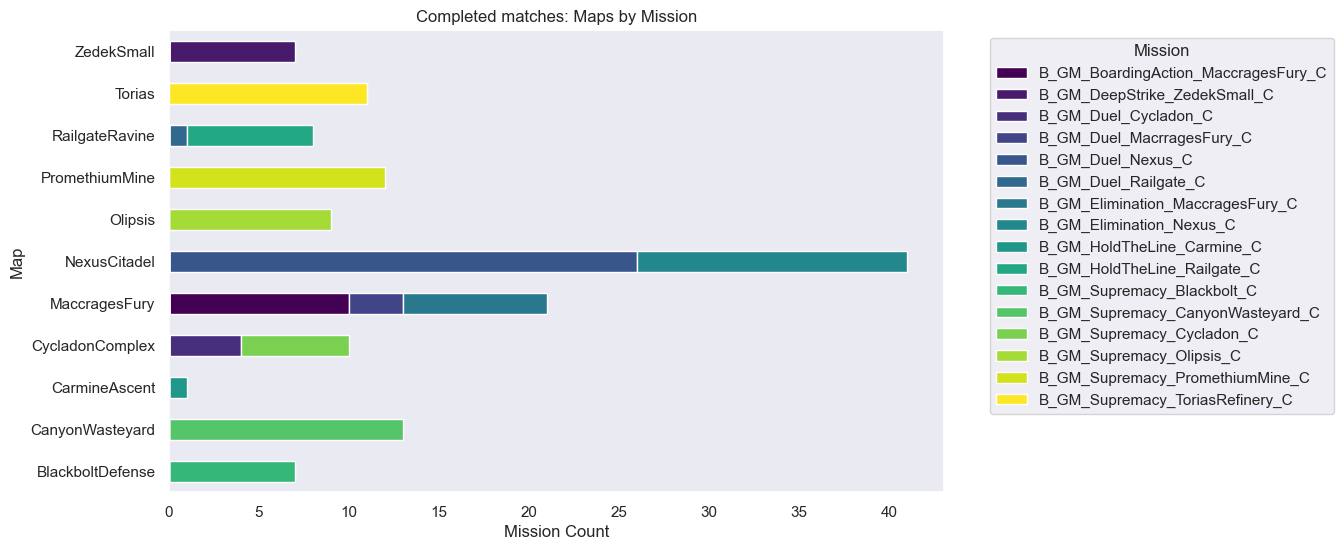

In [35]:
# Get the counts of each mission for each map
mission_counts = match_end_df.groupby(['map', 'mission']).size().unstack(fill_value=0)

# Create a horizontal bar plot
ax = mission_counts.plot(kind='barh', stacked=True, colormap='viridis', figsize=(10, 6))

# Customize the plot
ax.set_xlabel('Mission Count')
ax.set_ylabel('Map')
ax.set_title('Completed matches: Maps by Mission')

# Move the legend outside the plot
ax.legend(title='Mission', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

## Teams Win Rates

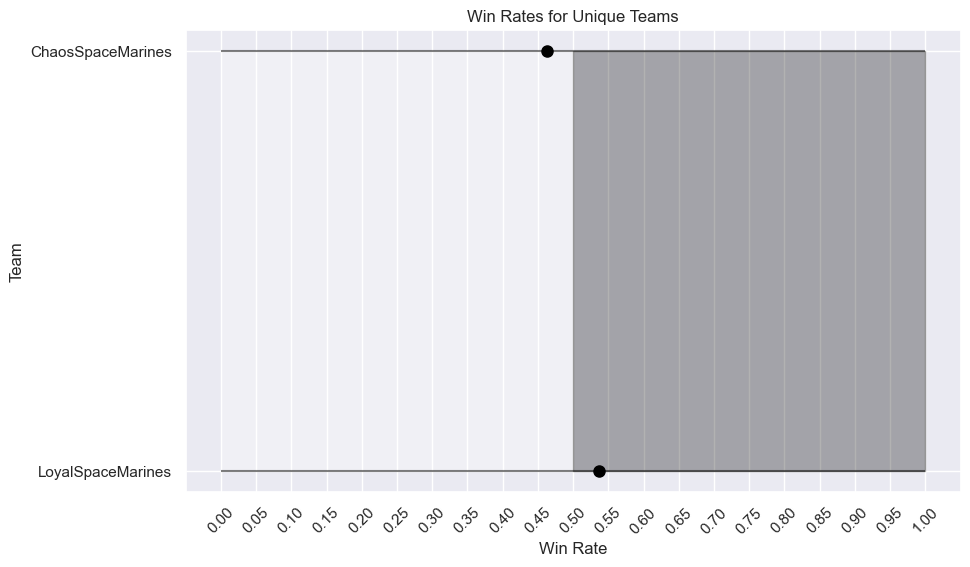

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame "match_end_df" with columns "winner_name", "t1_name", "t2_name", "t3_name", and "t4_name"

# Get all the unique strings from the DataFrame
all_teams = [s for s in match_end_df[["t1_name", "t2_name", "t3_name", "t4_name"]].values.ravel() if s]
unique_teams = pd.unique(all_teams)

# Create a dictionary to store the win rates for each string
win_rates = {}

# Calculate win rates for each string
for team in unique_teams:
    total_matches = match_end_df[
        (match_end_df["t1_name"] == team) |
        (match_end_df["t2_name"] == team) |
        (match_end_df["t3_name"] == team) |
        (match_end_df["t4_name"] == team)
        ]["winner_name"].count()

    wins = match_end_df[match_end_df["winner_name"] == team]["winner_name"].count()

    win_rate = wins / total_matches if total_matches > 0 else 0
    win_rates[team] = win_rate

# Convert the dictionary to a DataFrame
win_rates_df = pd.DataFrame(list(win_rates.items()), columns=["Team", "Win Rate"])

# Sort the DataFrame by win rate
win_rates_df = win_rates_df.sort_values(by="Win Rate", ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
# Plot horizontal lines for each 'map-mission'
plt.hlines(y=range(len(unique_teams)), xmin=0, xmax=1, color='k', alpha=0.5)

# Plot points representing the frequency of 'Defender' winners
plt.plot(win_rates_df["Win Rate"], win_rates_df["Team"], marker='o', color='black', linestyle='None', markersize=8)

# Fill the area left of 0.5 with red and right of 0.5 with blue
plt.fill_betweenx([0, len(unique_teams) - 1], 0, 0.5, color='white', alpha=0.3)
plt.fill_betweenx([0, len(unique_teams) - 1], 0.5, 1, color='black', alpha=0.3)

plt.xticks(np.arange(0, 1.05, 0.05), rotation=45)
plt.grid()

# Set labels for axes and title
plt.xlabel("Win Rate")
plt.ylabel("Team")
plt.title("Win Rates for Unique Teams")

# Display the plot
plt.show()

## Attacker defender matches

In [37]:
attacker_defender_match_end_df = match_end_df[match_end_df["winner_goal"].isin(["Attacker", "Defender"])]

In [38]:
attacker_defender_match_end_df["def_att_xp_ratio"] = attacker_defender_match_end_df["t2_xp"] / attacker_defender_match_end_df["t1_xp"]

attacker_defender_match_end_df["def_att_ks_ratio"] = attacker_defender_match_end_df["t2_ks_ratio"] / attacker_defender_match_end_df["t1_ks_ratio"]

attacker_defender_match_end_df = attacker_defender_match_end_df[attacker_defender_match_end_df['def_att_xp_ratio'].notna()]
attacker_defender_match_end_df = attacker_defender_match_end_df[attacker_defender_match_end_df['def_att_ks_ratio'].notna()]

### Win Rates

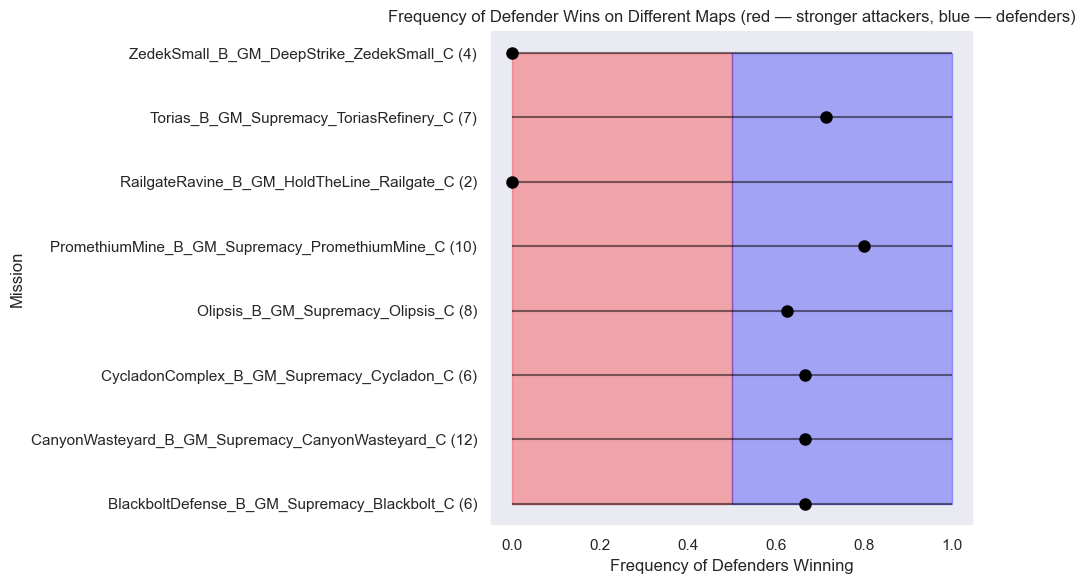

In [39]:
# Group the data by 'map-mission' and calculate the frequency of 'Defender' winners
frequency_df = attacker_defender_match_end_df.groupby('map-mission')['winner_goal'].apply(lambda x: (x == 'Defender').mean()).reset_index()
frequency_df.rename(columns={'winner_goal': 'Defender_Frequency'}, inplace=True)

# Sort the DataFrame by 'Defender_Frequency'
frequency_df = frequency_df.sort_values(by='Defender_Frequency')

# Get the count of rows for each mission
mission_counts = attacker_defender_match_end_df['map-mission'].value_counts().reindex(frequency_df['map-mission']).fillna(0)

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot horizontal lines for each 'map-mission'
ax.hlines(y=frequency_df.index, xmin=0, xmax=1, color='k', alpha=0.5)

# Plot points representing the frequency of 'Defender' winners
ax.plot(frequency_df['Defender_Frequency'], frequency_df.index, marker='o', color='black', linestyle='None', markersize=8)

# Fill the area left of 0.5 with red and right of 0.5 with blue
ax.fill_betweenx([0, len(frequency_df.index) - 1], 0, 0.5, color='red', alpha=0.3)
ax.fill_betweenx([0, len(frequency_df.index) - 1], 0.5, 1, color='blue', alpha=0.3)

# Customize the plot
ax.set_ylabel('Mission')
ax.set_xlabel('Frequency of Defenders Winning')
ax.set_title('Frequency of Defender Wins on Different Maps (red — stronger attackers, blue — defenders)')

# Set y-ticks to 'map-mission' values
y_ticks = [f"{mission} ({count})" for mission, count in zip(frequency_df['map-mission'], mission_counts)]
plt.yticks(frequency_df.index, y_ticks)

# Display the plot
plt.tight_layout()
plt.show()

## XP ratios

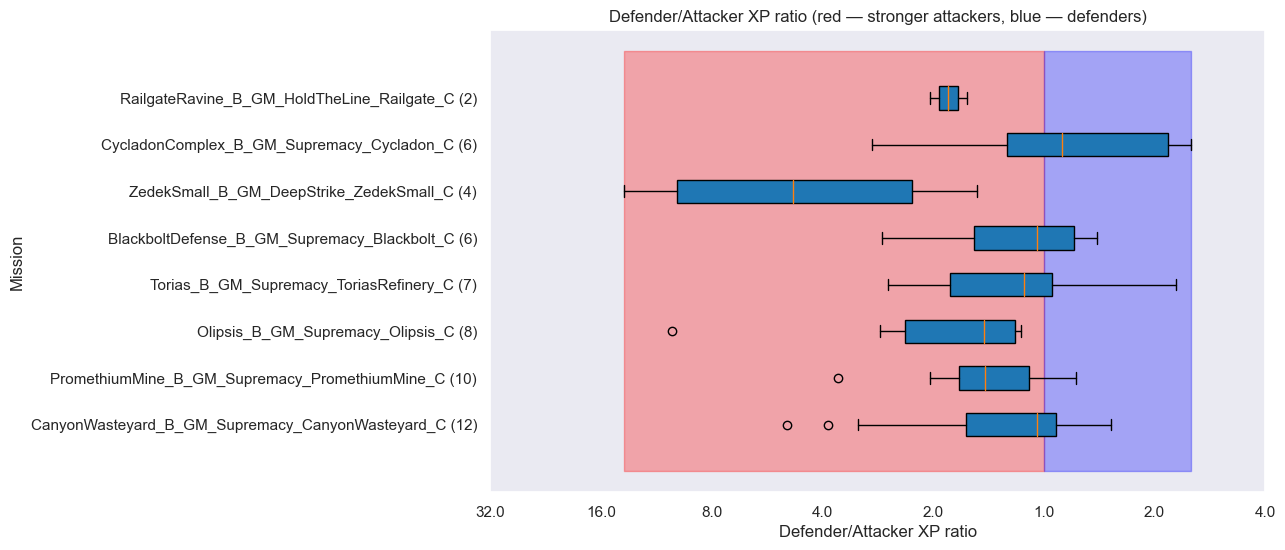

In [40]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Convert the "def_att_xp_ratio" column to a logarithmic scale
attacker_defender_match_end_df['def_att_xp_ratio_log2'] = np.log2(attacker_defender_match_end_df['def_att_xp_ratio'])

# Group the data by "map-mission" and extract unique labels
unique_labels = attacker_defender_match_end_df['map-mission'].unique()

unique_labels_counts = attacker_defender_match_end_df['map-mission'].value_counts().reindex(unique_labels).fillna(0)

# Create a boxplot with logarithmic x-axis
boxplot = ax.boxplot(
    [attacker_defender_match_end_df[attacker_defender_match_end_df['map-mission'] == label]['def_att_xp_ratio_log2'] for label in unique_labels],
    vert=False,
    patch_artist=True
)

# Fill the area left of 0.5 with red and right of 0.5 with blue
ax.fill_betweenx([0, len(unique_labels) + 1], min([x for x in attacker_defender_match_end_df['def_att_xp_ratio_log2'] if x != -np.inf]), 0, color='red', alpha=0.3)
ax.fill_betweenx([0, len(unique_labels) + 1], 0, max(attacker_defender_match_end_df['def_att_xp_ratio_log2']), color='blue', alpha=0.3)

# Set y-ticks to 'map-mission' values
y_ticks = [f"{mission} ({count})" for mission, count in zip(unique_labels, unique_labels_counts)]
plt.yticks(range(1, len(unique_labels) + 1), y_ticks)

# Set logarithmic tick labels on the x-axis
xticks, _ = plt.xticks()
xtick_labels = [f'{2**abs(x)}'.format(x) for x in xticks]
plt.xticks(xticks, xtick_labels)

# Set labels for axes and title
ax.set_xlabel('Defender/Attacker XP ratio')
ax.set_ylabel('Mission')
ax.set_title('Defender/Attacker XP ratio (red — stronger attackers, blue — defenders)')

# Show the plot
plt.show()

### Kill/Spawn ratios

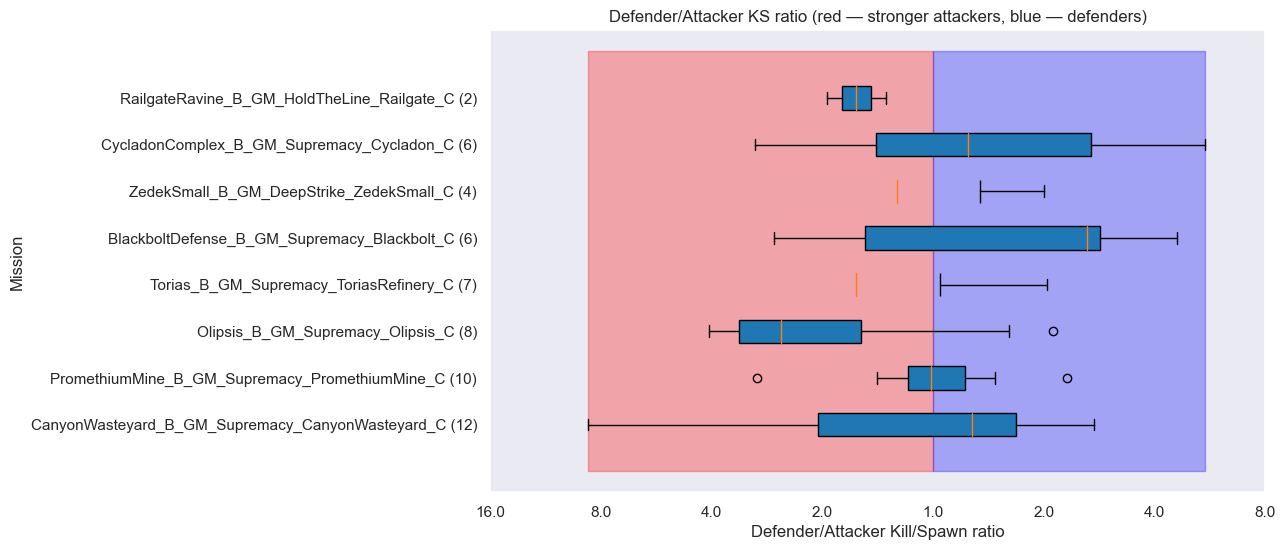

In [41]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Convert the "def_att_xp_ratio" column to a logarithmic scale
attacker_defender_match_end_df['def_att_ks_ratio_log2'] = np.log2(attacker_defender_match_end_df['def_att_ks_ratio'])

# Group the data by "map-mission" and extract unique labels
unique_labels = attacker_defender_match_end_df['map-mission'].unique()

unique_labels_counts = attacker_defender_match_end_df['map-mission'].value_counts().reindex(unique_labels).fillna(0)

# Create a boxplot with logarithmic x-axis
boxplot = ax.boxplot(
    [attacker_defender_match_end_df[attacker_defender_match_end_df['map-mission'] == label]['def_att_ks_ratio_log2'] for label in unique_labels],
    vert=False,
    patch_artist=True
)

# Fill the area left of 0.5 with red and right of 0.5 with blue
ax.fill_betweenx([0, len(unique_labels) + 1], min([x for x in attacker_defender_match_end_df['def_att_ks_ratio_log2'] if x != -np.inf]), 0, color='red', alpha=0.3)
ax.fill_betweenx([0, len(unique_labels) + 1], 0, max(attacker_defender_match_end_df['def_att_ks_ratio_log2']), color='blue', alpha=0.3)

# Set y-ticks to 'map-mission' values
y_ticks = [f"{mission} ({count})" for mission, count in zip(unique_labels, unique_labels_counts)]
plt.yticks(range(1, len(unique_labels) + 1), y_ticks)

# Set logarithmic tick labels on the x-axis
xticks, _ = plt.xticks()
xtick_labels = [f'{2**abs(x):.1f}'.format(x) for x in xticks]
plt.xticks(xticks, xtick_labels)

# Set labels for axes and title
ax.set_xlabel('Defender/Attacker Kill/Spawn ratio')
ax.set_ylabel('Mission')
ax.set_title('Defender/Attacker KS ratio (red — stronger attackers, blue — defenders)')

# Show the plot
plt.show()

## Symmetrical matches

In [42]:
symmetrical_match_end_df = match_end_df[match_end_df["winner_goal"] == "Standard"]

In [43]:
symmetrical_match_end_df["max_xp_ratio"] = symmetrical_match_end_df[["t1_xp", "t2_xp", "t3_xp", "t4_xp"]].max(axis=1) / symmetrical_match_end_df[["t1_xp", "t2_xp", "t3_xp", "t4_xp"]].replace(0, None).min(axis=1)

symmetrical_match_end_df["max_ks_ratio"] = symmetrical_match_end_df[["t1_ks_ratio", "t2_ks_ratio", "t3_ks_ratio", "t4_ks_ratio"]].max(axis=1) / symmetrical_match_end_df[["t1_ks_ratio", "t2_ks_ratio", "t3_ks_ratio", "t4_ks_ratio"]].replace(0, None).min(axis=1)

symmetrical_match_end_df = symmetrical_match_end_df[symmetrical_match_end_df['max_xp_ratio'].notna()]
symmetrical_match_end_df = symmetrical_match_end_df[symmetrical_match_end_df['max_ks_ratio'].notna()]

## Win rates

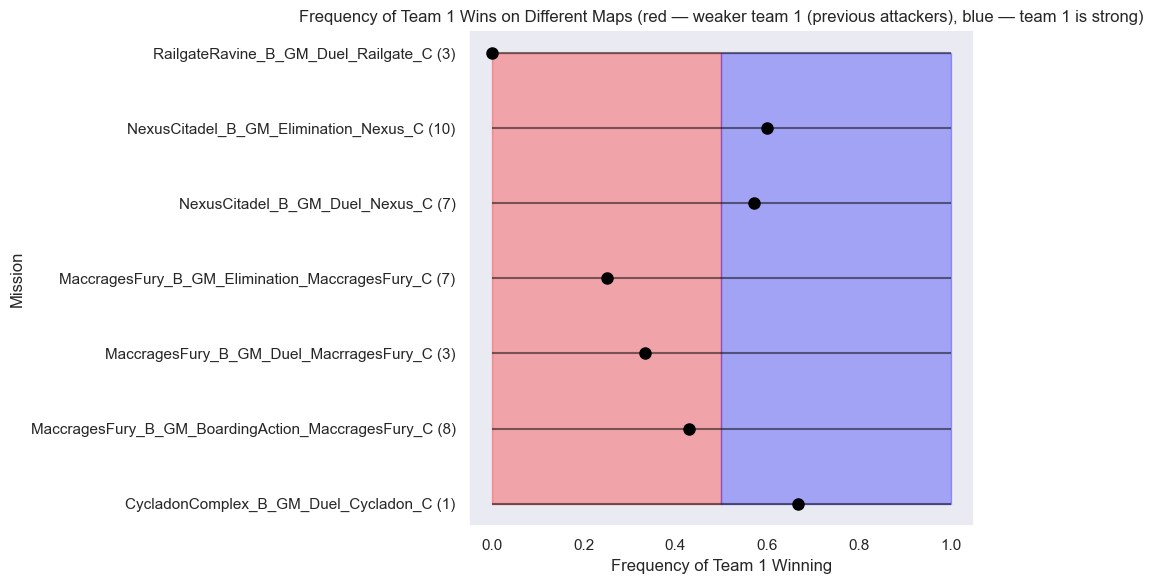

In [44]:
# Group the data by 'map-mission' and calculate the frequency of 'Defender' winners
frequency_df = symmetrical_match_end_df.groupby('map-mission').apply(lambda x: (x['winner_name'] == x['t1_name']).mean()).reset_index()
frequency_df.rename(columns={0: 'T1_Frequency'}, inplace=True)

# Get the count of rows for each mission
mission_counts = symmetrical_match_end_df['map-mission'].value_counts().reindex(frequency_df['map-mission']).fillna(0)

# Sort the DataFrame by 'T1_Frequency'
frequency_df = frequency_df.sort_values(by='T1_Frequency')

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot horizontal lines for each 'map-mission'
ax.hlines(y=frequency_df.index, xmin=0, xmax=1, color='k', alpha=0.5)

# Plot points representing the frequency of 'Defender' winners
ax.plot(frequency_df['T1_Frequency'], frequency_df.index, marker='o', color='black', linestyle='None', markersize=8)

# Fill the area left of 0.5 with red and right of 0.5 with blue
ax.fill_betweenx([0, len(frequency_df.index) - 1], 0, 0.5, color='red', alpha=0.3)
ax.fill_betweenx([0, len(frequency_df.index) - 1], 0.5, 1, color='blue', alpha=0.3)

# Customize the plot
ax.set_ylabel('Mission')
ax.set_xlabel('Frequency of Team 1 Winning')
ax.set_title('Frequency of Team 1 Wins on Different Maps (red — weaker team 1 (previous attackers), blue — team 1 is strong)')

# Set y-ticks to 'map-mission' values and add mission row counts to labels
y_ticks = [f"{mission} ({count})" for mission, count in zip(frequency_df['map-mission'], mission_counts)]
plt.yticks(frequency_df.index, y_ticks)

# Display the plot
plt.tight_layout()
plt.show()

## XP Ratios

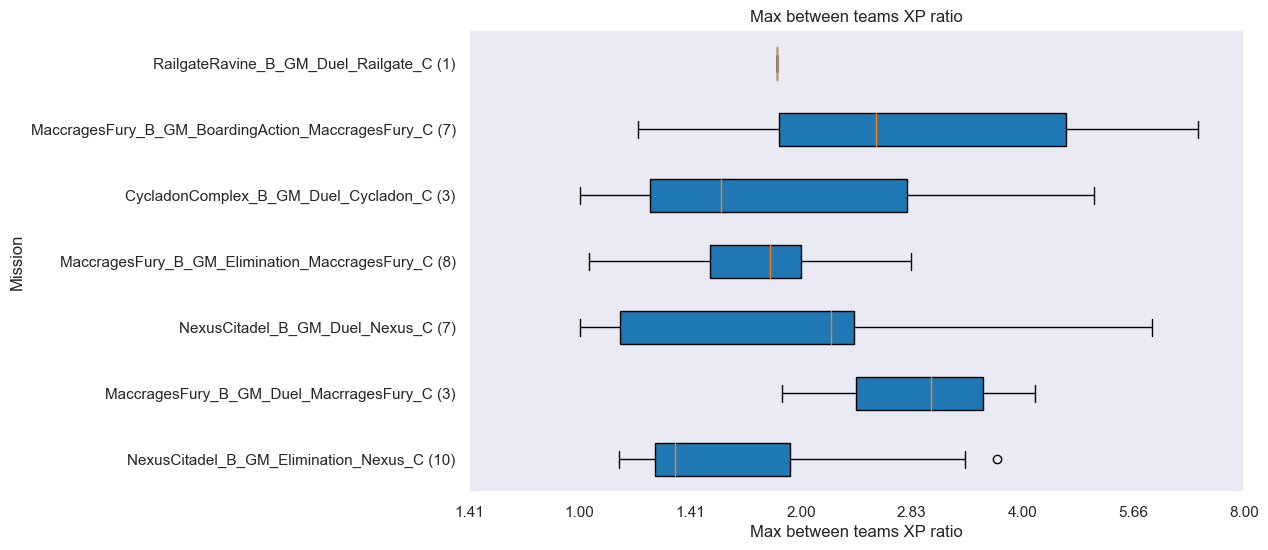

In [45]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Convert the "def_att_xp_ratio" column to a logarithmic scale
symmetrical_match_end_df['max_xp_ratio_log2'] = np.log2(np.float32(symmetrical_match_end_df['max_xp_ratio']))

# Group the data by "map-mission" and extract unique labels
unique_labels = symmetrical_match_end_df['map-mission'].unique()

unique_labels_counts = symmetrical_match_end_df['map-mission'].value_counts().reindex(unique_labels).fillna(0)

# Create a boxplot with logarithmic x-axis
boxplot = ax.boxplot(
    [symmetrical_match_end_df[symmetrical_match_end_df['map-mission'] == label]['max_xp_ratio_log2'] for label in unique_labels],
    vert=False,
    patch_artist=True
)

# Set y-ticks to 'map-mission' values
y_ticks = [f"{mission} ({count})" for mission, count in zip(unique_labels, unique_labels_counts)]
plt.yticks(range(1, len(unique_labels) + 1), y_ticks)

# Set logarithmic tick labels on the x-axis
xticks, _ = plt.xticks()
xtick_labels = [f'{2**abs(x):.2f}'.format(x) for x in xticks]
plt.xticks(xticks, xtick_labels)

# Set labels for axes and title
ax.set_xlabel('Max between teams XP ratio')
ax.set_ylabel('Mission')
ax.set_title('Max between teams XP ratio')

# Show the plot
plt.show()

## KS ratios

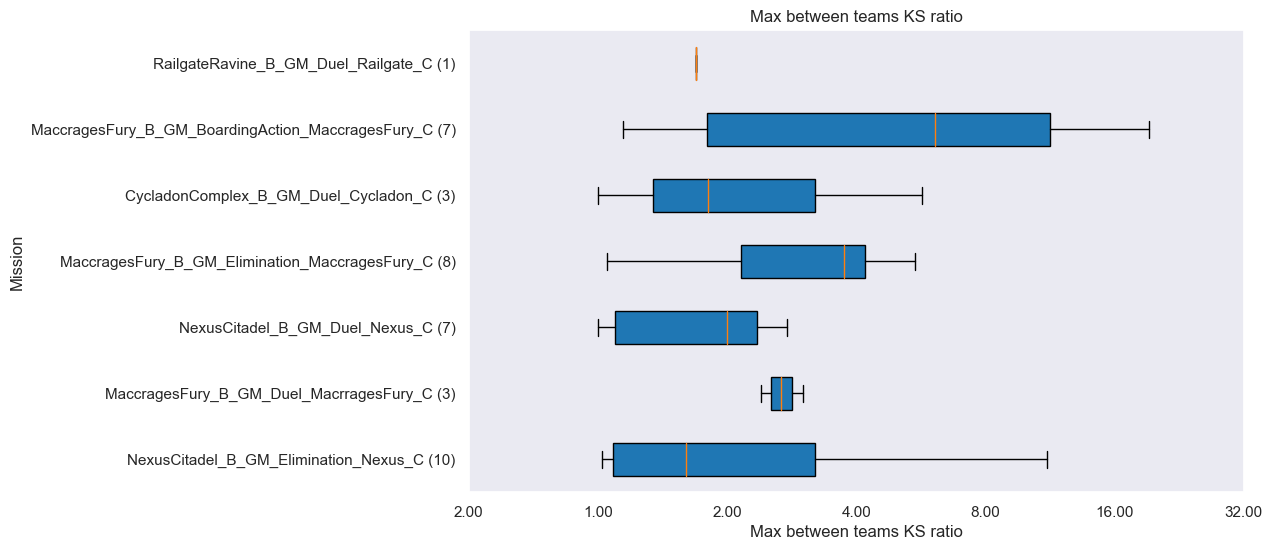

In [46]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Convert the "def_att_xp_ratio" column to a logarithmic scale
symmetrical_match_end_df['max_ks_ratio_log2'] = np.log2(np.float32(symmetrical_match_end_df['max_ks_ratio']))

# Group the data by "map-mission" and extract unique labels
unique_labels = symmetrical_match_end_df['map-mission'].unique()

unique_labels_counts = symmetrical_match_end_df['map-mission'].value_counts().reindex(unique_labels).fillna(0)

# Create a boxplot with logarithmic x-axis
boxplot = ax.boxplot(
    [symmetrical_match_end_df[symmetrical_match_end_df['map-mission'] == label]['max_ks_ratio_log2'] for label in unique_labels],
    vert=False,
    patch_artist=True
)

# Set y-ticks to 'map-mission' values
y_ticks = [f"{mission} ({count})" for mission, count in zip(unique_labels, unique_labels_counts)]
plt.yticks(range(1, len(unique_labels) + 1), y_ticks)

# Set logarithmic tick labels on the x-axis
xticks, _ = plt.xticks()
xtick_labels = [f'{2**abs(x):.2f}'.format(x) for x in xticks]
plt.xticks(xticks, xtick_labels)

# Set labels for axes and title
ax.set_xlabel('Max between teams KS ratio')
ax.set_ylabel('Mission')
ax.set_title('Max between teams KS ratio')

# Show the plot
plt.show()

# Heatmaps

## Damage dealers

In [44]:
x_points = list(damage_df["ic_x"])
y_points = list(damage_df["ic_y"])

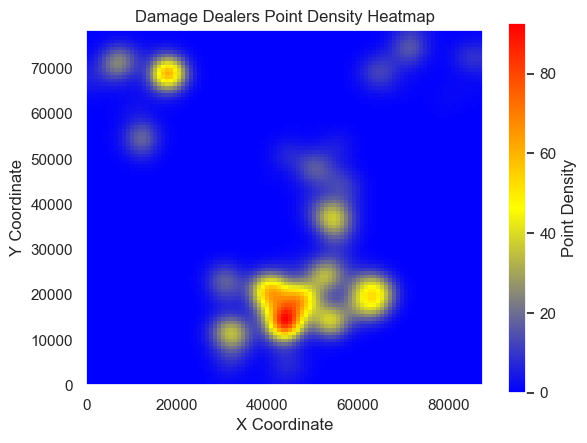

In [45]:
from matplotlib.colors import LinearSegmentedColormap

# Create a 2D histogram to represent point density
heatmap, xedges, yedges = np.histogram2d(x_points, y_points, bins=100)

# Smooth the heatmap using Gaussian convolution
from scipy.ndimage import gaussian_filter

heatmap = gaussian_filter(heatmap, sigma=3)

# Define a custom colormap (blue, yellow, red)
colors = [(0, 'blue'), (0.5, 'yellow'), (1, 'red')]
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

# Create the heatmap plot
plt.imshow(heatmap.T, origin='lower', extent=[0, xedges.max(), 0, yedges.max()], cmap=custom_cmap)
plt.colorbar(label='Point Density')  # Add a colorbar for reference
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Damage Dealers Point Density Heatmap')

plt.show()